In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
results_path = '../metrics/results/'

In [3]:
csv_paths = ['../metrics/results/cartolastd.csv', 
             '../metrics/results/cifar10cnn.csv',
             '../metrics/results/esc50.csv',
             '../metrics/results/fashion.csv',
             '../metrics/results/gaussians.csv',
             '../metrics/results/nnset.csv',
             '../metrics/results/qtables.csv',
             '../metrics/results/quickdraw.csv',
             '../metrics/results/sorts.csv',
             '../metrics/results/walk.csv']

In [4]:
def get_method(name):
    s = name
    s = s.split('/')[1]
    s = s.split('-', 1)[1]

    if s.startswith('tsne_s1'):
        return 'TF-tSNE'
    elif s.startswith('tsne_s4'):
        return 'G-tSNE'
    elif s.startswith('dtsne'):
        return 'dtSNE'
    elif s.startswith('ldtsne'):
        return 'ldtSNE'
    elif s.startswith('pcadtsne'):
        return 'pcdtSNE'
    elif s.startswith('pca_s1'):
        return 'TF-PCA'        
    elif s.startswith('pca_s4'):
        return 'G-PCA'
    elif s.startswith('umap_s1'):
        return 'TF-UMAP'        
    elif s.startswith('umap_s4'):
        return 'G-UMAP'
    else:
        return s.split('_')[0]

In [5]:
df_metrics = pd.DataFrame()
for p in csv_paths:
    df = pd.read_csv(p)
    df = df.drop(['spat_kl', 'stab_kl'], axis=1)  # Bad metric
    # Extract dataset and method into own column
    df.columns = np.concatenate([['name'], df.columns.values[1:]])
    df['dataset'] = df.name.str.extract(r'.*/(.*).*')[0].str.split(r'[_-]').str[0]
    df['method'] = df['name'].apply(get_method)
    df = df.set_index('name')
    
    # Remove CAE and CVAE 
    df = df[df['method'] != 'C2AE']
    df = df[df['method'] != 'C2VAE']
    
    # Average nh and np metrics 
    nh_cols = [c for c in df.columns if 'spat_nh_' in c]
    df['spat_nh_mean'] = np.mean(df[nh_cols], axis=1)

    np_cols = [c for c in df.columns if 'spat_np_' in c]
    df['spat_np_mean'] = np.mean(df[np_cols], axis=1)
    
    np_cols = [c for c in df.columns if 'spat_trust_' in c]
    df['spat_trust_mean'] = np.mean(df[np_cols], axis=1)
    
    np_cols = [c for c in df.columns if 'spat_cont_' in c]
    df['spat_cont_mean'] = np.mean(df[np_cols], axis=1)
    
    df_metrics = pd.concat([df_metrics, df])

In [6]:
datasets = df_metrics['dataset'].factorize()[1]
for dataset in datasets:
    methods = df_metrics[df_metrics['dataset'] == dataset]['method']
    
    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_s']]
    stab_df = (df - df.min())/(df.max() - df.min())
    stab_df['stab_stress_s'] = 1 - stab_df['stab_stress_s']
#     display(stab_df)

    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_s']]
    spat_df = (df - df.min())/(df.max() - df.min())
    spat_df['spat_stress_s'] = 1 - spat_df['spat_stress_s']
#     display(spat_df)

    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_nh_mean', 'spat_np_mean', 'spat_trust_mean', 'spat_cont_mean']]
    neigh_df = (df - df.min())/(df.max() - df.min())
#     display(neigh_df)
#     display((stab_df.mean(axis=1) + spat_df.mean(axis=1) + neigh_df.mean(axis=1)).sort_values(ascending=False))

In [7]:
colors = {
    'AE' : '#71B7DA',
    'VAE' : '#4292C6',
    'dtSNE' : '#A63603',
    'TF-tSNE' : '#D94801',
    'G-tSNE' : '#F16913',
    'TF-UMAP' : '#807DBA',
    'G-UMAP' : '#BDBDDC',
    'TF-PCA' : '#9DD986',
    'G-PCA' : '#659C40',
    'ldtSNE' : '#C000C0',
    'pcdtSNE' : '#FFC0FF'    
}

In [8]:
stab_mean = pd.DataFrame()
spat_mean = pd.DataFrame()
neigh_mean = pd.DataFrame()

for dataset in datasets:
    methods = df_metrics[df_metrics['dataset'] == dataset]['method']
    
    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_s']]
    stab_df = (df - df.min())/(df.max() - df.min())
    stab_df['stab_stress_s'] = 1 - stab_df['stab_stress_s']
    df = stab_df.mean(axis=1)
    df = df.to_frame()
    df['method'] = methods
    stab_mean = stab_mean.merge(df.groupby('method').mean(), left_index=True, right_index=True, how='outer')

    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_s']]
    spat_df = (df - df.min())/(df.max() - df.min())
    spat_df['spat_stress_s'] = 1 - spat_df['spat_stress_s']
    df = spat_df.mean(axis=1)
    df = df.to_frame()
    df['method'] = methods
    spat_mean = spat_mean.merge(df.groupby('method').mean(), left_index=True, right_index=True, how='outer')

    
    df = df_metrics[df_metrics['dataset'] == dataset]
    df = df[['spat_nh_mean', 'spat_np_mean', 'spat_trust_mean', 'spat_cont_mean']]
    neigh_df = (df - df.min())/(df.max() - df.min())
    df = neigh_df.mean(axis=1)
    df = df.to_frame()
    df['method'] = methods
    neigh_mean = neigh_mean.merge(df.groupby('method').mean(), left_index=True, right_index=True, how='outer')

In [9]:
spat_mean.columns = datasets
neigh_mean.columns = datasets
stab_mean.columns = datasets

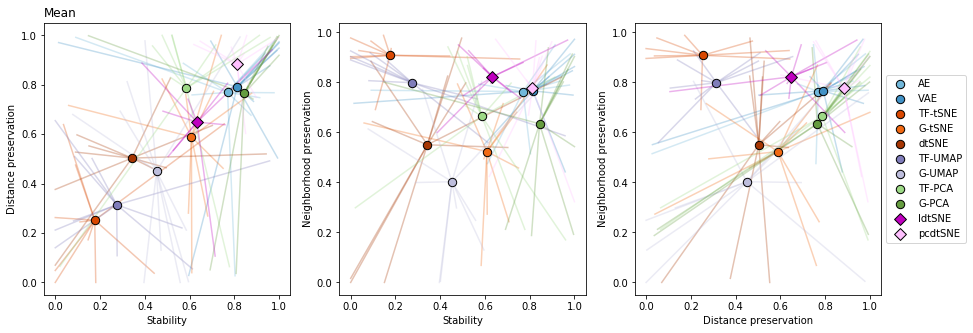

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].set_title('Mean', loc='left')
for i, name in enumerate(methods):
    marker = 'D' if name in ['pcdtSNE', 'ldtSNE'] else 'o'

    where = np.where(stab_mean.mean(axis=1).index == name)[0]
    
    x_mean = stab_mean.mean(axis=1)[where]
    y_mean = spat_mean.mean(axis=1)[where]
    axs[0].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name], edgecolor='black', linewidth=1, zorder=10)
    for x,y in zip(stab_mean.iloc[where].values.flatten(), spat_mean.iloc[where].values.flatten()):
        axs[0].plot([x, x_mean], [y, y_mean], c=colors[name], alpha=0.3)
    axs[0].set_xlabel('Stability', fontsize=10)
    axs[0].set_ylabel('Distance preservation', fontsize=10)

    
    x_mean = stab_mean.mean(axis=1)[where]
    y_mean = neigh_mean.mean(axis=1)[where]
    axs[1].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name], edgecolor='black', linewidth=1, zorder=10)
    for x,y in zip(stab_mean.iloc[where].values.flatten(), neigh_mean.iloc[where].values.flatten()):
        axs[1].plot([x, x_mean], [y, y_mean], c=colors[name], alpha=0.3)
    axs[1].set_xlabel('Stability', fontsize=10)
    axs[1].set_ylabel('Neighborhood preservation', fontsize=10)

    x_mean = spat_mean.mean(axis=1)[where]
    y_mean = neigh_mean.mean(axis=1)[where]
    axs[2].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name],
                   edgecolor='black', linewidth=1, zorder=10, label=name)
    for x,y in zip(spat_mean.iloc[where].values.flatten(), neigh_mean.iloc[where].values.flatten()):
        axs[2].plot([x, x_mean], [y, y_mean], c=colors[name], alpha=0.3)
    axs[2].set_xlabel('Distance preservation', fontsize=10)
    axs[2].set_ylabel('Neighborhood preservation', fontsize=10)
#     break

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

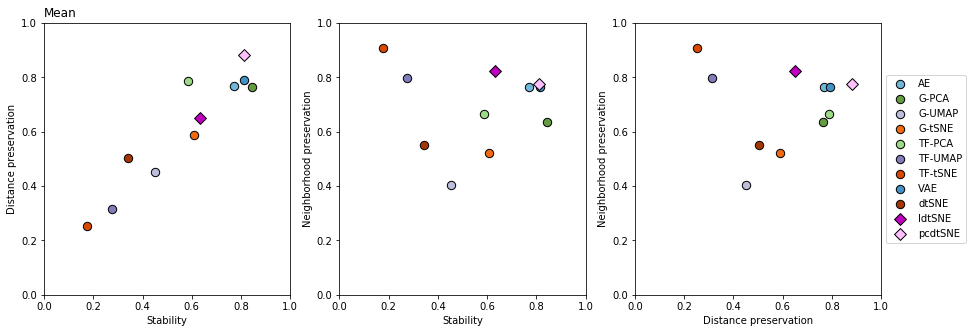

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
axs[0].set_title('Mean', loc='left')
for i, name in enumerate(np.unique(df_metrics['method'])):
    marker = 'D' if name in ['pcdtSNE', 'ldtSNE'] else 'o'

    where = np.where(stab_mean.mean(axis=1).index == name)[0]
    
    x_mean = stab_mean.mean(axis=1)[where]
    y_mean = spat_mean.mean(axis=1)[where]
    axs[0].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name], edgecolor='black', linewidth=1, zorder=10)
    axs[0].set_xlabel('Stability', fontsize=10)
    axs[0].set_ylabel('Distance preservation', fontsize=10)
    axs[0].set_xlim([0,1])
    axs[0].set_ylim([0,1])

    x_mean = stab_mean.mean(axis=1)[where]
    y_mean = neigh_mean.mean(axis=1)[where]
    axs[1].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name], edgecolor='black', linewidth=1, zorder=10)
    axs[1].set_xlabel('Stability', fontsize=10)
    axs[1].set_ylabel('Neighborhood preservation', fontsize=10)
    axs[1].set_xlim([0,1])
    axs[1].set_ylim([0,1])
    
    x_mean = spat_mean.mean(axis=1)[where]
    y_mean = neigh_mean.mean(axis=1)[where]
    axs[2].scatter(x_mean, y_mean, s=70, marker=marker, c=colors[name],
                   edgecolor='black', linewidth=1, zorder=10, label=name)
    axs[2].set_xlabel('Distance preservation', fontsize=10)
    axs[2].set_ylabel('Neighborhood preservation', fontsize=10)
    axs[2].set_xlim([0,1])
    axs[2].set_ylim([0,1])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

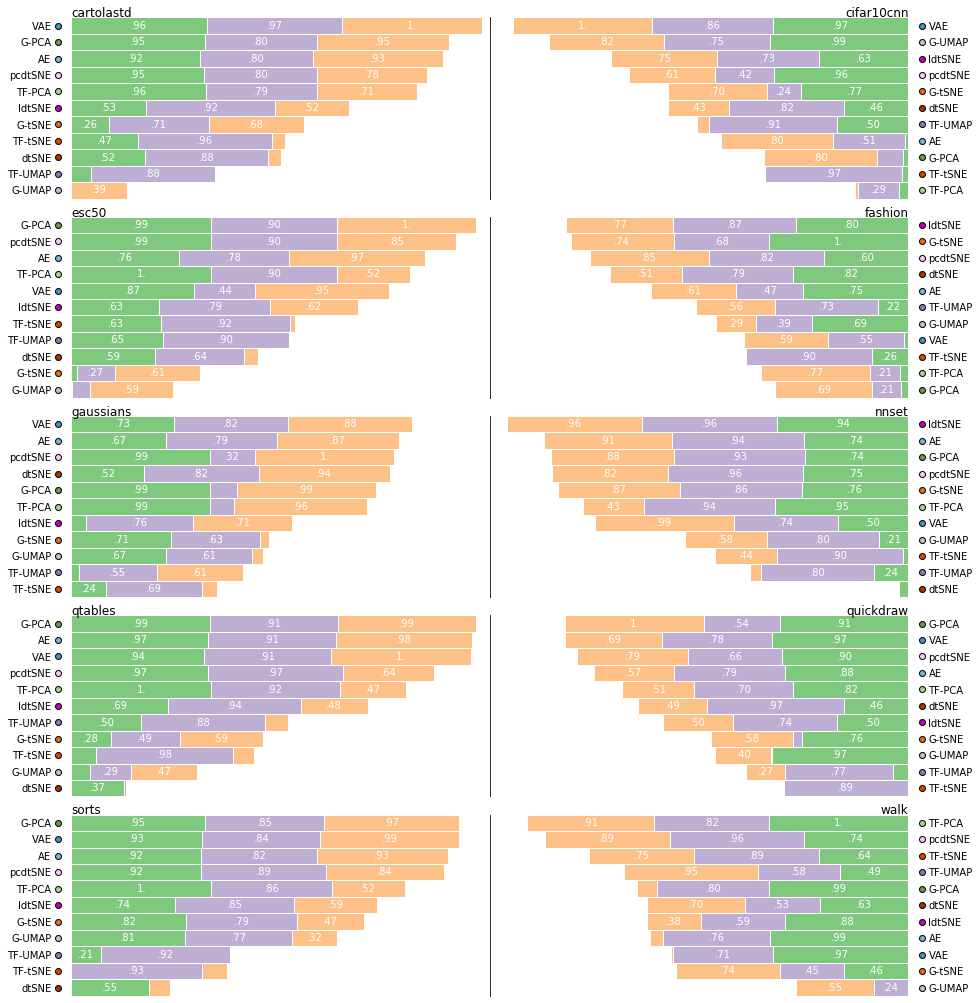

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=len(datasets)//2, figsize=(15,18), gridspec_kw={'hspace':0.1, 'wspace':0.})

for i, c in enumerate(datasets):
    ax = axs.flatten()[i] 
    order = ((spat_mean[c] + neigh_mean[c] + stab_mean[c]).sort_values()).index    
    labels = order

    ax.barh(labels, spat_mean[c].loc[order].values, color='#7fc97f', 
            edgecolor='white', height=1, label='Spat')
    ax.barh(labels, neigh_mean[c].loc[order].values, color='#beaed4',
            left=spat_mean[c].loc[order].values, 
            edgecolor='white', height=1, label='Neigh')
    ax.barh(labels, stab_mean[c].loc[order].values, color='#fdc086',
            left=spat_mean[c].loc[order].values + neigh_mean[c].loc[order].values,
            edgecolor='white', height=1, label='Stab')

    ax.tick_params(axis="y",direction="in", pad=20)

    for y, name in enumerate(order):
        marker = 'D' if name in ['pcdTSNE', 'ldTSNE'] else 'o'
        ax.scatter([-0.1], [y], marker=marker, color=colors[name], edgecolor='black', linewidth=1, clip_on=False)
        
        if spat_mean[c].loc[name] > .2:
            if spat_mean[c].loc[name] == 1.:
                text = '1.'
            else:
                text = str(float(spat_mean[c].loc[name]))[1:4]
            x = (spat_mean[c]/2).loc[name]
            ax.text(x, y, text, ha='center', va='center', color='white')
        
        if neigh_mean[c].loc[name] > .2:
            if neigh_mean[c].loc[name] == 1.:
                text = '1.'
            else:
                text = str(float(neigh_mean[c].loc[name]))[1:4]
            x = spat_mean[c].loc[name] + (neigh_mean[c]/2).loc[name]
            ax.text(x, y, text, ha='center', va='center', color='white')

        if stab_mean[c].loc[name] > .2:
            if stab_mean[c].loc[name] == 1.:
                text = '1.'
            else:
                text = str(float(stab_mean[c].loc[name]))[1:4]
            x = spat_mean[c].loc[name] + neigh_mean[c].loc[name] + (stab_mean[c]/2).loc[name]
            ax.text(x, y, text, ha='center', va='center', color='white')
    

    ax.set_ylim([-0.5, len(methods) - 0.5])
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    if i % 2 == 1:
        ax.set_title(c, loc='right', pad=.3)
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_xlim([3,0])
        ax.spines['left'].set_visible(True)
    else:
        ax.set_title(c, loc='left', pad=.3)
        ax.set_xlim([0,3])
        ax.spines['right'].set_visible(True)
    
    
#     break

## Green = Distance preservation
## Purple = Neighborhood preservation
## Orange = Stability

In [13]:
metrics = ['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_s', 'v_spacer_1', 'spat_nh_mean', 'spat_np_mean', 'spat_trust_mean', 'spat_cont_mean', 'v_spacer_2', 'stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_s']
invert_colormap = ['stab_stress_n', 'stab_stress_s', 'spat_stress_n', 'spat_stress_s']

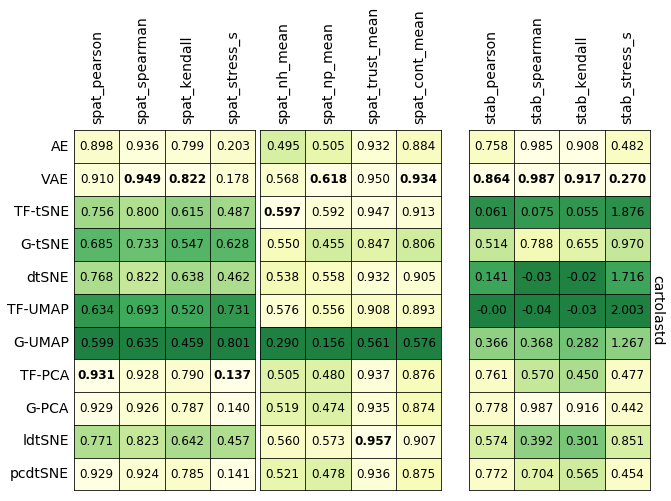

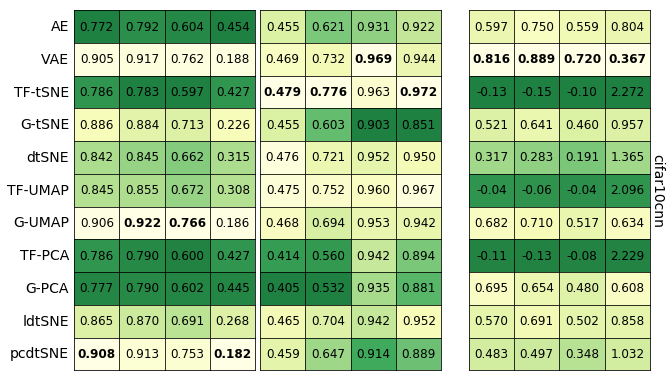

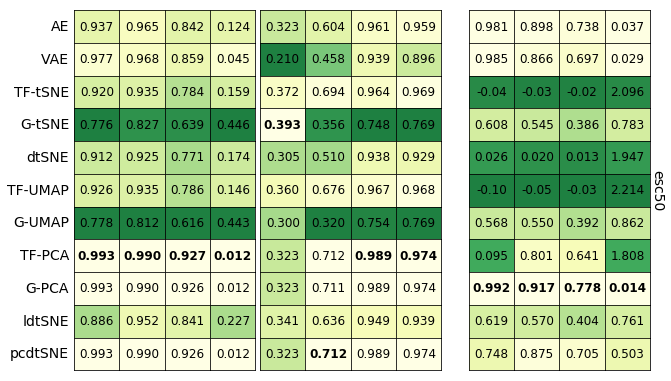

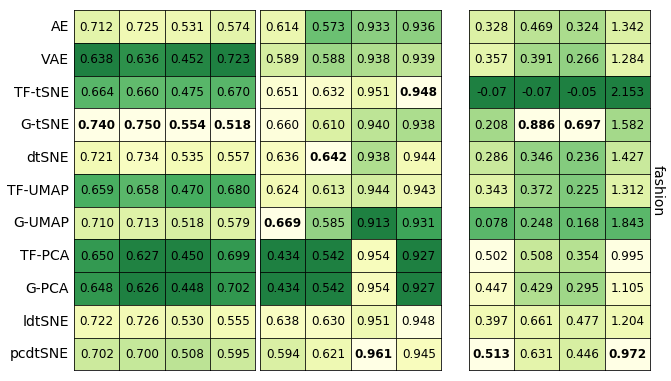

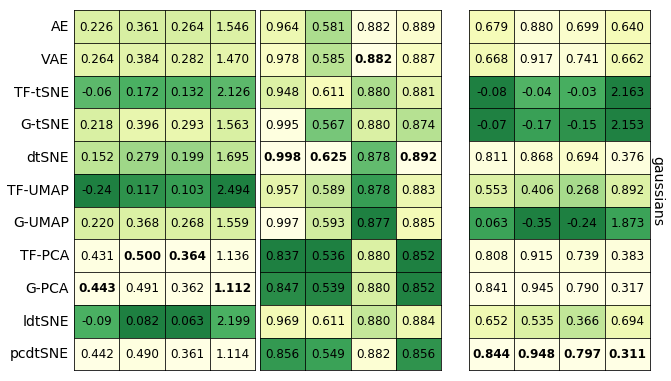

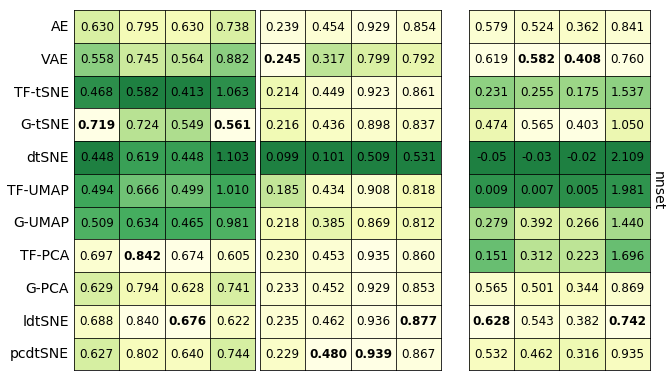

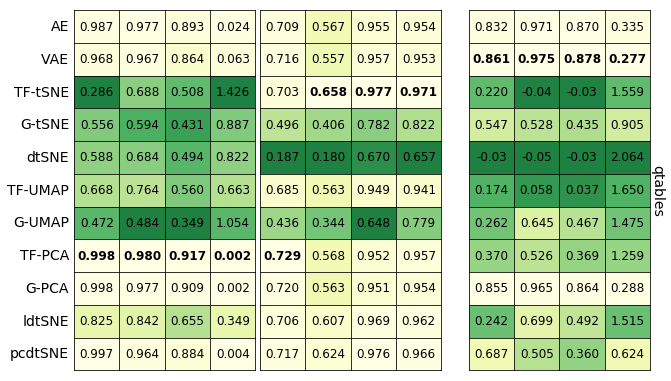

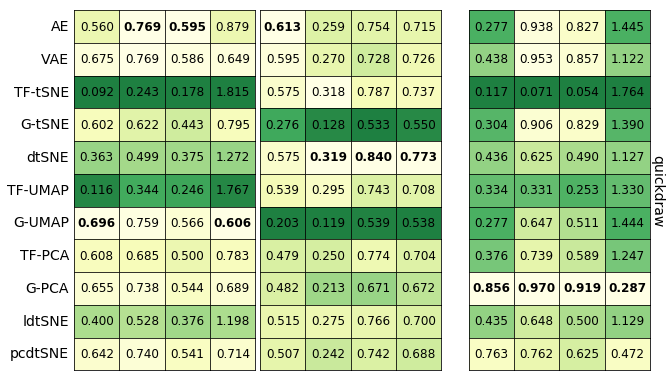

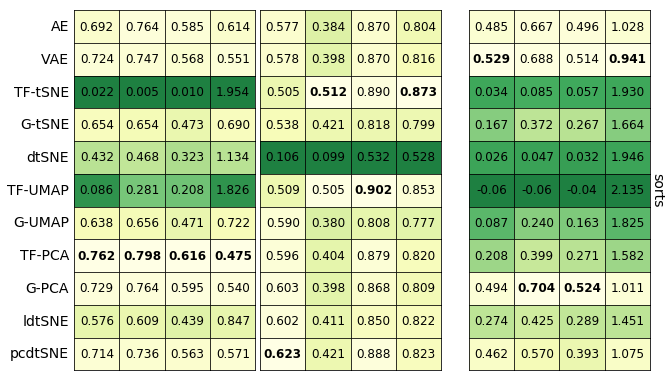

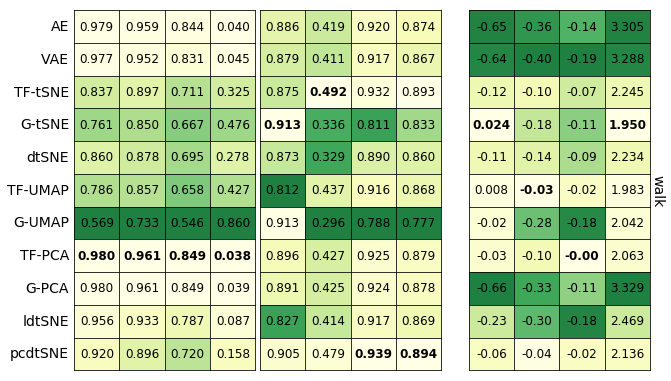

In [14]:
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

def make_cell(df, index, metric, ax):
    
    avg = df[metric][index]

    colormap_max = max(df[metric])
    colormap_min = min(df[metric])
    metric_max = max(df[metric])
    metric_min = min(df[metric])

    interval = abs(colormap_max - colormap_min)
    if metric in invert_colormap:
        cmap = plt.cm.get_cmap('YlGn')        
        norm = matplotlib.colors.Normalize(vmin=colormap_min, 
                                           vmax=colormap_max + 0.3 * interval)        
    else:
        cmap = plt.cm.get_cmap('YlGn_r')
        norm = matplotlib.colors.Normalize(vmin=colormap_min - 0.3 * interval, 
                                           vmax=colormap_max)

    cell_color = cmap(norm(avg))
    ax.set_facecolor(cell_color)
    
    text = str(avg)[:5]
    if (avg == max(df[metric]) and metric not in invert_colormap) or (avg == min(df[metric]) and metric in invert_colormap):
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, transform=ax.transAxes, fontweight='bold') # Need to be sure of the center
    else:
        ax.text(0.5, 0.5, text, ha='center', va='center', fontsize=12, transform=ax.transAxes) # Need to be sure of the center
    plt.subplots_adjust(left=0.1, right=0.9, top=1.0, bottom=0.0)    
    ax.set_yticks([])
    ax.set_xticks([])
    

for dataset_index, dataset in enumerate(df_metrics['dataset'].factorize()[1]):
    df = df_metrics[df_metrics['dataset'] == dataset]
    heights = [1] * len(df)
    widths = [1.0] * 4 + [0.1] + [1.0] * 4 + [0.6] + [1.0] * 4
#     heights = [1.0] * 2 + [0.1] + [1.0] * 3 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 1
    fig, axs = plt.subplots( len(df), 14, sharex='col', sharey='row', figsize=(10,5),
                            gridspec_kw={'hspace': 0, 'wspace': 0, 
                                         'width_ratios':widths, 'height_ratios':heights})
    
    fig.suptitle(dataset, x=.91, y=.5, ha='center', va='center', rotation=270, fontsize=14)

    for col_index, metric in enumerate(metrics):        
        if metric.startswith('v_spacer'):
            for row_index in range(len(df)):
                ax = axs[row_index, col_index]
                ax.set_visible(False)
        else: 
            for row_index, index in enumerate(df.index):                
                ax = axs[row_index, col_index]

                if col_index == 0:
#                     ax.set_ylabel(index[7:], rotation=0, ha='right', va='center', labelpad=5, fontsize=14)
                    ax.set_ylabel(df['method'][index], rotation=0, ha='right', va='center', labelpad=5, fontsize=14)
                if row_index == 0 and dataset_index == 0:
                    ax.set_title(metric, rotation=90, ha='center', va='bottom', fontsize=14)

                make_cell(df, index, metric, ax)


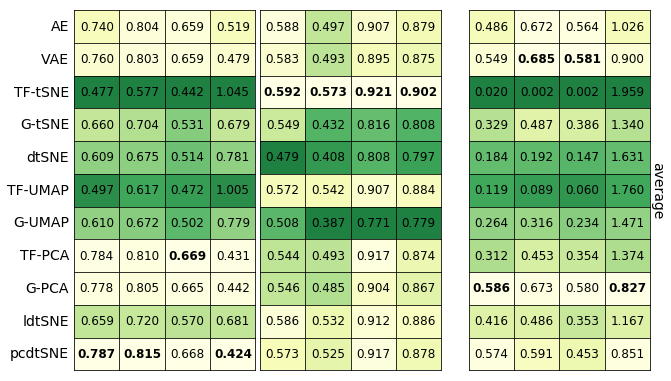

In [34]:
order = df_metrics[df_metrics['dataset'] == dataset]['method'].to_list()

df = df_metrics.groupby('method').mean()
#     df = df_metrics[df_metrics['dataset'] == dataset]
heights = [1] * len(df)
widths = [1.0] * 4 + [0.1] + [1.0] * 4 + [0.6] + [1.0] * 4
#     heights = [1.0] * 2 + [0.1] + [1.0] * 3 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 2 + [0.1] + [1.0] * 1
fig, axs = plt.subplots( len(df), 14, sharex='col', sharey='row', figsize=(10,5),
                        gridspec_kw={'hspace': 0, 'wspace': 0, 
                                     'width_ratios':widths, 'height_ratios':heights})

fig.suptitle('average', x=.91, y=.5, ha='center', va='center', rotation=270, fontsize=14)

for col_index, metric in enumerate(metrics):        
    if metric.startswith('v_spacer'):
        for row_index in range(len(df)):
            ax = axs[row_index, col_index]
            ax.set_visible(False)
    else: 
        for row_index, index in enumerate(order):                
            ax = axs[row_index, col_index]

            if col_index == 0:
#                     ax.set_ylabel(index[7:], rotation=0, ha='right', va='center', labelpad=5, fontsize=14)
                ax.set_ylabel(index, rotation=0, ha='right', va='center', labelpad=5, fontsize=14)
            if row_index == 0 and dataset_index == 0:
                ax.set_title(metric, rotation=90, ha='center', va='bottom', fontsize=14)

            make_cell(df, index, metric, ax)
